# NLP 기초: Tokenization + Embedding 이해

### 학습 목표

1. **토큰화(Tokenization) 이해**
   - 단어 단위 토큰화 (형태소 분석)
   - 서브워드 토큰화 (WordPiece, SentencePiece)
   - 한국어 토큰화 도구 활용 (Kiwi, BERT, BGE-M3)

2. **임베딩(Embedding) 이해**
   - 단어 임베딩 (BoW, TF-IDF, Word2Vec)
   - 문장 임베딩 (평균 기반, SBERT)
   - 임베딩 벡터의 의미와 활용

3. **텍스트 유사도 측정**
   - 유사도 메트릭 (유클리드 거리, 코사인 유사도, 내적)
   - 실제 문장 간 유사도 비교
   - 유사도 결과 시각화

### 필요 패키지

```bash
# uv 환경
uv add kiwipiepy numpy==1.26.4 torch==2.2.2 transformers==4.41.2 scikit-learn gensim sentence-transformers==2.7.0 matplotlib seaborn

# pip 환경
pip install kiwipiepy torch transformers scikit-learn gensim sentence-transformers matplotlib seaborn
```

---

## 1. Tokenization (토큰화)

- **개념:** 텍스트를 분석 가능한 작은 단위로 나누는 과정이다. 컴퓨터가 자연어를 이해하기 위한 첫 번째 단계로, 의미 있는 최소 단위로 텍스트를 분할한다.

    - 단어 단위 토큰화 (Word Tokenization)
    - 서브워드 토큰화 (Subword Tokenization)

### 1.1 **단어 단위 토큰화 (Word Tokenization)**

- **특징:**
    - 형태소 분석을 기반으로 의미 있는 최소 단위로 분리
    - 조사, 어미 등 문법적 요소도 개별 토큰으로 분리
    - 한국어의 교착어 특성을 잘 반영

- **활용 분야:**
    - 문장 분석, 품사 태깅
    - 텍스트 분류, 감성 분석
    - 구문 분석, 의존 구문 분석

- **예시:** `"자연어처리는 재미있다"` → `["자연어", "처리", "는", "재미", "있", "다"]` -> token화

In [1]:
from kiwipiepy import Kiwi
import time
from functools import wraps
import warnings

# 불필요한 경고 메시지 숨기기
warnings.filterwarnings('ignore')

def measure_time(func):
    """실행 시간 측정 데코레이터"""
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{func.__name__} 실행 시간: {end-start:.4f}초")
        return result
    return wrapper

# Kiwi 형태소 분석기 로드
kiwi = Kiwi()

In [2]:
@measure_time
def tokenize_with_kiwi(text):
    """토큰화 함수"""
    try:
        return kiwi.tokenize(text)
    except Exception as e:
        print(f"토큰화 오류: {e}")
        return []
    
# 토큰화 실행
text = "자연어처리를 공부하는 것은 정말 흥미롭고 유용합니다!"
tokens = tokenize_with_kiwi(text)

print("토큰화 결과:")
tokens

# 많이 발견되는 것을 위주로 체크

tokenize_with_kiwi 실행 시간: 1.3434초
토큰화 결과:


[Token(form='자연어 처리', tag='NNP', start=0, len=5),
 Token(form='를', tag='JKO', start=5, len=1),
 Token(form='공부', tag='NNG', start=7, len=2),
 Token(form='하', tag='XSV', start=9, len=1),
 Token(form='는', tag='ETM', start=10, len=1),
 Token(form='것', tag='NNB', start=12, len=1),
 Token(form='은', tag='JX', start=13, len=1),
 Token(form='정말', tag='MAG', start=15, len=2),
 Token(form='흥미', tag='NNG', start=18, len=2),
 Token(form='롭', tag='XSA-I', start=20, len=1),
 Token(form='고', tag='EC', start=21, len=1),
 Token(form='유용', tag='NNG', start=23, len=2),
 Token(form='하', tag='XSA', start=25, len=1),
 Token(form='ᆸ니다', tag='EF', start=25, len=3),
 Token(form='!', tag='SF', start=28, len=1)]

In [3]:
# Kiwipiepy에서 체크하는 품사 태그를 한국어 명칭으로 매핑하는 딕셔너리
pos_dict = {
    # 체언
    'NNG': '일반명사', 'NNP': '고유명사', 'NNB': '의존명사', 'NP': '대명사', 'NR': '수사',
    # 용언
    'VV': '동사', 'VA': '형용사', 'VX': '보조용언', 'VCP': '긍정지정사', 'VCN': '부정지정사',
    # 관형사/부사
    'MM': '관형사', 'MAG': '일반부사', 'MAJ': '접속부사',
    # 조사
    'JKS': '주격조사', 'JKC': '보격조사', 'JKG': '관형격조사', 'JKO': '목적격조사', 
    'JKB': '부사격조사', 'JKV': '호격조사', 'JKQ': '인용격조사', 'JX': '보조사', 'JC': '접속조사',
    # 어미
    'EP': '선어말어미', 'EF': '종결어미', 'EC': '연결어미', 'ETN': '명사형전성어미', 'ETM': '관형사형전성어미',
    # 접사
    'XPN': '체언접두사', 'XSN': '명사파생접미사', 'XSV': '동사파생접미사', 'XSA': '형용사파생접미사', 'XSA-I': '형용사파생접미사(불규칙)', 'XR': '어근',
    # 기호
    'SF': '마침표류', 'SP': '쉼표류', 'SS': '따옴표류', 'SE': '줄임표', 'SO': '붙임표',
    'SL': '외국어', 'SH': '한자', 'SN': '숫자', 'SW': '기타기호'
}

# 결과 출력 
print(f"{'번호':>3} {'단어':^8} {'품사태그':^8} {'한국어품사':^12} {'위치':^6}")
print("-" * 45)
for i, token in enumerate(tokens, 1):
    korean_pos = pos_dict.get(token.tag, token.tag)
    pos_range = f"{token.start}-{token.start + token.len}"
    print(f"{i:>3} {token.form:^8} {token.tag:^8} {korean_pos:^12} {pos_range:^6}")

 번호    단어      품사태그      한국어품사       위치  
---------------------------------------------
  1  자연어 처리    NNP        고유명사      0-5  
  2    를       JKO       목적격조사      5-6  
  3    공부      NNG        일반명사      7-9  
  4    하       XSV      동사파생접미사     9-10 
  5    는       ETM      관형사형전성어미   10-11 
  6    것       NNB        의존명사     12-13 
  7    은        JX        보조사      13-14 
  8    정말      MAG        일반부사     15-17 
  9    흥미      NNG        일반명사     18-20 
 10    롭      XSA-I   형용사파생접미사(불규칙) 20-21 
 11    고        EC        연결어미     21-22 
 12    유용      NNG        일반명사     23-25 
 13    하       XSA      형용사파생접미사   25-26 
 14   ᆸ니다       EF        종결어미     25-28 
 15    !        SF        마침표류     28-29 


### 1.2 **서브워드 토큰화 (Subword Tokenization)**

**특징:**
- 형태소보다 작은 의미 단위 사용
- 자주 등장하는 문자열 패턴을 토큰으로 활용
- OOV(Out-of-Vocabulary) 문제 해결에 효과적

**활용 분야:**
- 신조어, 전문용어 처리
- 기계 번역, 언어 모델링
- 다국어 NLP 모델

### 1.2.1 유명한 주요 서브워드 알고리즘 상세 (Subword Algorithms)


#### 1. **BPE (Byte Pair Encoding)**
가장 기본적인 서브워드 분절 방식으로, **'데이터에 가장 자주 등장하는 글자 쌍(Pair)'을 순차적으로 병합**하는 방식입니다.

* **작동 원리 (Bottom-up):**
    1. 모든 단어를 문자(Character) 단위로 분리합니다. -> low -> l o w
    2. 가장 빈도수가 높은 문자 쌍(Bi-gram)을 찾습니다.(2개씩 상으로 되어있는 것)
    3. 이 쌍을 하나의 토큰으로 병합하고, 단어 목록을 업데이트합니다.
    4. 설정된 어휘 집합(Vocab) 크기에 도달할 때까지 2~3번 과정을 반복합니다.(현재 우리가 사용하고 있는 모델은 단어가 20만개 ~ 25만개 정도)

* **예시:**
    * **초기 상태:** `l o w` (5회), `l o w e r` (2회), `n e w e r` (6회), `w i d e r` (3회)
    * **1회차 병합:** 가장 자주 등장하는 `e`와 `r`의 쌍(`er`)을 병합
        → `l o w`, `l o w er`, `n e w er`, `w i d er`
    * **최종 결과:** 'low', 'er', 'new', 'wid' 등의 서브워드가 생성되어, **`lower`** 라는 단어는 `low` + `er`로 토큰화됩니다.
* **결론은 자주 등장하는 것을 추출**

#### 2. **WordPiece**
Google이 BERT를 학습시키기 위해 BPE를 개선한 알고리즘입니다. BPE와 유사하지만 병합 기준이 단순히 '빈도'가 아니라 **'우도(Likelihood)'를 가장 높이는 쌍**을 선택합니다.

* **작동 원리:**
    * 빈도수만 고려하면 자주 나오는 단어끼리만 뭉쳐질 수 있습니다.
    * WordPiece는 아래 공식을 사용하여, 두 글자가 따로 있을 때보다 합쳐졌을 때의 중요도가 높은 쌍을 먼저 병합합니다.
    * **수식:** $Score = \frac{Frequency(pair)}{Frequency(first) \times Frequency(second)}$
    * **접두어 표시:** 단어의 첫 부분이 아닌 나머지 부분(중간, 끝)에는 `##`을 붙여 구분합니다.

* **예시 (BERT Tokenizer):**
    * 입력 단어: **`embeddings`**
    * 토큰화 결과: `['em', '##bed', '##ding', '##s']`
    * **해설:** `em`은 단어의 시작임. `##bed`는 앞에 다른 글자가 붙어 있다는 의미입니다.

#### 3. **SentencePiece**
Google이 만든 오픈소스 라이브러리로, **'공백(Space)'도 하나의 문자로 취급**하는 것이 가장 큰 특징입니다.

 **작동 원리:**
    * 기존 BPE나 WordPiece는 띄어쓰기를 기준으로 먼저 단어를 나눈 뒤(Pre-tokenization) 서브워드로 쪼개지만, SentencePiece는 문장 전체를 그냥 하나의 문자열로 봅니다.
    * 공백을 언더바(`_`, U+2581)로 치환하여 처리하므로, 띄어쓰기가 없는 언어(중국어, 일본어)나 띄어쓰기 규칙이 복잡한 언어(한국어)에 매우 강력합니다.

* **예시:**
    * 입력 문장: **`Hello World`**
    * 토큰화 결과: `['_Hello', '_World']`
    * **복원(Detokenization):** 단순히 모든 토큰을 합친 뒤 `_`를 공백으로 바꾸기만 하면 원문이 완벽하게 복원됩니다.


**주요 알고리즘 비교:**

| 구분 | BPE | WordPiece | SentencePiece |
| --- | --- | --- | --- |
| **병합 기준** | **빈도수 (Frequency)** | **우도 (Likelihood)** | **BPE 또는 Unigram** |
| **특수 기호** | `</w>` (단어 끝) 등 | `##` (단어의 중간/끝) | `_` (공백) |
| **전처리** | 띄어쓰기 기준 분리 필요 | 띄어쓰기 기준 분리 필요 | **필요 없음 (Raw Text 입력)** |
| **주요 모델** | GPT-2, GPT-3, RoBERTa | BERT, DistilBERT | T5, XLM-R, ALBERT |
| **적합성** | 영어 등 띄어쓰기 명확한 언어 | 영어, 의미론적 분석 중요 시 | **한국어, 다국어 처리** |


### 1.2.2 Byte-Level BPE (BBPE)

최신 LLM(GPT 시리즈, LLaMA)에서 표준처럼 사용되는 방식으로, 기존 BPE의 한계인 OOV 문제를 근본적으로 해결한 방식입니다.

* **작동 원리:**
    1. 텍스트를 사람이 보는 '문자(Character)'가 아닌 컴퓨터가 처리하는 **'UTF-8 바이트(Byte)'** 단위로 분해합니다.
    2. 256개의 바이트를 기본 어휘로 시작하여 BPE 알고리즘(빈도 기반 병합)을 수행합니다.

* **특징:**
    * **OOV(Out-Of-Vocabulary) 완전 해결:** 어떤 언어, 이모지, 특수문자가 들어와도 바이트 단위로 쪼개서 표현하므로 `<UNK>`(Unknown Token)이 발생하지 않습니다.
    * **다국어 처리 우수:** 별도의 언어별 전처리 없이도 모든 언어를 처리할 수 있습니다.

* **예시:**
    * 입력: "A😊"
    * 처리: 'A'(1바이트) + '😊'(4바이트) → 총 5개의 바이트 토큰으로 시작해 자주 나오는 패턴끼리 병합.
    * 사용 모델: **GPT-2, GPT-3, GPT-4, RoBERTa, LLaMA**

---


#### **실습**: BERT 토크나이저 (WordPiece)

- **Huggingface KcBERT 토크나이저** 활용 
- 개념:
    - SentencePiece 기반 서브워드 토크나이저 사용
    - 한국어에 특화된 어휘 사전(vocab) 보유
    - 특수 토큰: [CLS], [SEP], [MASK], [PAD], [UNK]
- 특징:
    - 문장 시작: [CLS] 토큰 추가
    - 문장 구분: [SEP] 토큰 사용
    - 서브워드 분리: '##' 접두어로 표시
    - 예시: `"자연어처리"` → `['자연', '##어', '##처리']`
    - 최대 길이 처리: max_length로 자동 truncation 
    - 참조: https://huggingface.co/beomi/kcbert-base
- 설치:
    - pip install torch transformers 또는 uv add torch==2.2.2 transformers

In [4]:
# 허깅페이스 트랜스포머 라이브러리에서 토크나이저 로드
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('beomi/kcbert-base')

tokenizer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


BertTokenizerFast(name_or_path='beomi/kcbert-base', vocab_size=30000, model_max_length=300, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [5]:
# 토큰화 수행 : 문장 -> 토큰들의 리스트
text = "자연어처리를 공부합니다"
tokens = tokenizer.tokenize(text)

tokens
# 모델마다 토큰화가 전부 다르다.
# 앞에 ## 이런 것들은 3만개가 안된 경우이다. 자연, 공부 같은 경우는 3만개가 이상인 경우 ##가 붙지 않는다

['자연', '##어', '##처리', '##를', '공부', '##합니다']

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_tokenization(texts, tokenizer):
    """토큰화 분석 함수"""
    results = []
    
    for text in texts:
        try:
            # 토큰화
            tokens = tokenizer.tokenize(text)
            token_ids = tokenizer.encode(text)
            
            # 특수 토큰 분석
            special_tokens = [token for token in tokens if token in ['[CLS]', '[SEP]', '[MASK]', '[PAD]', '[UNK]']]
            subword_tokens = [token for token in tokens if token.startswith('##')]
            
            results.append({
                'text': text,
                'token_count': len(tokens),
                'subword_count': len(subword_tokens),
                'special_count': len(special_tokens),
                'tokens': tokens
            })
        except Exception as e:
            print(f"토큰화 오류 - {text}: {e}")
            
    return results

# 테스트 문장들
test_texts = [
    "자연어처리를 공부합니다",
    "인공지능과 머신러닝은 미래기술이다", 
    "COVID-19로 인한 비대면 수업이 증가했다",
    "스마트폰의 음성인식 기능이 발전했다"
]

# 토큰화 분석
results = analyze_tokenization(test_texts, tokenizer)

for i, result in enumerate(results, 1):
    print(f"\n{i}. 원문: {result['text']}")
    print(f"   토큰 수: {result['token_count']}개")
    print(f"   서브워드: {result['subword_count']}개")
    print(f"   토큰들: {result['tokens']}")
    print("-" * 30)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



1. 원문: 자연어처리를 공부합니다
   토큰 수: 6개
   서브워드: 4개
   토큰들: ['자연', '##어', '##처리', '##를', '공부', '##합니다']
------------------------------

2. 원문: 인공지능과 머신러닝은 미래기술이다
   토큰 수: 11개
   서브워드: 8개
   토큰들: ['인공', '##지능', '##과', '머', '##신', '##러', '##닝', '##은', '미래', '##기술', '##이다']
------------------------------

3. 원문: COVID-19로 인한 비대면 수업이 증가했다
   토큰 수: 15개
   서브워드: 8개
   토큰들: ['C', '##O', '##V', '##I', '##D', '-', '19', '##로', '인한', '비', '##대면', '수업', '##이', '증가', '##했다']
------------------------------

4. 원문: 스마트폰의 음성인식 기능이 발전했다
   토큰 수: 8개
   서브워드: 4개
   토큰들: ['스마트폰', '##의', '음성', '##인식', '기능', '##이', '발전', '##했다']
------------------------------


#### **실습**: SentencePiece 토크나이저 (bge-m3 모델)

- **Huggingface Transformers** 라이브러리 사용

In [7]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3") # 한국어 처리하는 모델 중에서는 현재 가장 좋은 모델
# model = AutoModel.from_pretrained("BAAI/bge-m3")

In [8]:
text = "자연어처리를 공부합니다"
tokens = tokenizer.tokenize(text)
print(tokens)

# 사용하는 모델마다 토큰화 방식이 다르다.

['▁자연', '어', '처리', '를', '▁공부', '합니다']


In [9]:
# 토큰화 분석
results = analyze_tokenization(test_texts, tokenizer)

for i, result in enumerate(results, 1):
    print(f"\n{i}. 원문: {result['text']}")
    print(f"   토큰 수: {result['token_count']}개")
    print(f"   토큰들: {result['tokens']}")
    print("-" * 30)


1. 원문: 자연어처리를 공부합니다
   토큰 수: 6개
   토큰들: ['▁자연', '어', '처리', '를', '▁공부', '합니다']
------------------------------

2. 원문: 인공지능과 머신러닝은 미래기술이다
   토큰 수: 10개
   토큰들: ['▁인공지능', '과', '▁머', '신', '러', '닝', '은', '▁미래', '기술', '이다']
------------------------------

3. 원문: COVID-19로 인한 비대면 수업이 증가했다
   토큰 수: 12개
   토큰들: ['▁CO', 'VID', '-19', '로', '▁인한', '▁비', '대', '면', '▁수업', '이', '▁증가', '했다']
------------------------------

4. 원문: 스마트폰의 음성인식 기능이 발전했다
   토큰 수: 9개
   토큰들: ['▁스마트폰', '의', '▁음성', '인', '식', '▁기능', '이', '▁발전', '했다']
------------------------------


- 각 단어를 토큰 단위로 나눔
- 토큰을 벡터화로 변경
- 즉, 문장을 처리할 때는 토큰 -> 벡터화 -> 딥러닝
- 토크나이저가 중요, 하지만 너무 딥함

---

## 2. Embedding (임베딩 or 임베딩 벡터)

텍스트를 컴퓨터가 이해할 수 있는 수치 벡터로 변환하는 기술이다. 의미적으로 유사한 텍스트는 벡터 공간에서 가까운 거리에 위치하도록 한다.

### 2.1 **단어 임베딩 (Word Embedding)**

- 개념:
    - 자연어를 컴퓨터가 이해할 수 있는 벡터 형태로 변환하는 기술
    - 각 단어를 고정된 크기의 실수 벡터로 표현
    - 비슷한 의미를 가진 단어들은 벡터 공간에서 서로 가까운 거리에 위치

- 기법: 
    - Bag of Words (BoW)
    - TF-IDF (Term Frequency-Inverse Document Frequency)
    - Word2Vec

#### 2.1.1 Bag of Words (BoW) 단어로 이루어진 주머니

**특징:**
- 단어의 출현 빈도를 벡터로 표현
- 단어 순서 정보는 무시
- 희소(sparse) 벡터 생성

* uv add scikit-learn

In [10]:
from sklearn.feature_extraction.text import CountVectorizer 
import pandas as pd
import numpy as np

# 한국어 텍스트 예제
texts = [
    "자연어 처리를 공부합니다",
    "자연어는 컴퓨터 언어가 아니라 인간의 언어입니다", 
    "자연어 수업 시간에 자연어 처리 방법을 배우고 있습니다"
]

# BoW 벡터화
def create_bow_vectors(texts):
    # 토큰화된 텍스트로 변환
    tokenized_texts = []
    for text in texts:
        tokens = tokenize_with_kiwi(text) # 형태소 분석
        token_words = [token.form for token in tokens if token.tag not in ['SF', 'SP']]  # 구두점 제외
        tokenized_texts.append(' '.join(token_words))
    
    # BoW 벡터화
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(tokenized_texts)
    
    return bow_matrix, vectorizer, tokenized_texts

bow_matrix, vectorizer, tokenized_texts = create_bow_vectors(texts)

tokenize_with_kiwi 실행 시간: 0.0007초
tokenize_with_kiwi 실행 시간: 0.0009초
tokenize_with_kiwi 실행 시간: 0.0008초


In [11]:
# 결과 정리
feature_names = vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(bow_matrix.toarray(), 
                     columns=feature_names,
                     index=[f'문서{i+1}' for i in range(len(texts))])

bow_df
# 표를 만드는 것이 Bag of Words
# 해당 표를 학습 시켰을 때 얻는 것 -> ㅂ니다 공부 방법 배우 수업... -> Vocab 크기
# Sparse Vector 희소벡터

,ᆸ니다,공부,방법,배우,수업,습니다,시간,아니,언어,연어,인간,자연어,처리,컴퓨터
문서1,1,1,0,0,0,0,0,0,0,0,0,1,1,0
문서2,1,0,0,0,0,0,0,1,2,1,1,0,0,1
문서3,0,0,1,1,1,1,1,0,0,0,0,2,1,0


In [12]:
print(f"어휘 사전 크기: {len(feature_names)}개")
# Vocab 크기

어휘 사전 크기: 14개


#### 2.1.2 TF-IDF (Term Frequency-Inverse Document Frequency) 조낸 중요!!!!!!!!!!!

**특징:**
- 단어의 중요도를 고려한 가중치 부여
- 희귀한 단어에 높은 가중치 부여
- 문서 집합 내에서 단어의 상대적 중요성 측정

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

def create_tfidf_vectors(texts):
    # 토큰화
    tokenized_texts = []
    for text in texts:
        tokens = tokenize_with_kiwi(text)
        token_words = [token.form for token in tokens if token.tag not in ['SF', 'SP']]
        tokenized_texts.append(' '.join(token_words))
    
    # TF-IDF 벡터화
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(tokenized_texts)
    
    return tfidf_matrix, tfidf, tokenized_texts

tfidf_matrix, tfidf, _ = create_tfidf_vectors(texts)

tokenize_with_kiwi 실행 시간: 0.0004초
tokenize_with_kiwi 실행 시간: 0.0008초
tokenize_with_kiwi 실행 시간: 0.0006초


In [14]:
# 결과 정리
feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), 
                       columns=feature_names,
                       index=[f'문서{i+1}' for i in range(len(texts))])

tfidf_df.round(3)
# 문서 내 상대적 중요도를 나타내는 TF-IDF 표
# 문장 내에서 빈도로만 체크하면 the is a 이런 관사 때문에, 하지만 중요하지 않은 단서이기 때문에 TF-IDF로 체크한다.
# TF / DF
# 이것을 계선한 것이 BM25, ELK
# 전문용어, 고유명사 찾을 때 많이 사용

,ᆸ니다,공부,방법,배우,수업,습니다,시간,아니,언어,연어,인간,자연어,처리,컴퓨터
문서1,0.46,0.605,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.460,0.460,0.000
문서2,0.26,0.000,0.000,0.000,0.000,0.000,0.000,0.341,0.683,0.341,0.341,0.000,0.000,0.341
문서3,0.00,0.000,0.356,0.356,0.356,0.356,0.356,0.000,0.000,0.000,0.000,0.541,0.271,0.000


#### 2.1.3 Word2Vec 사용할 일이 별로 없음

**특징:**
- 단어의 의미적 관계를 벡터 공간에 표현
- 문맥을 고려한 단어 표현
- CBOW와 Skip-gram 두 가지 아키텍처
- 임베딩 프로젝터: https://projector.tensorflow.org/
- 참조: https://ko.wikipedia.org/wiki/Gensim
- 설치: pip install gensim 또는 uv add gensim

**주의사항:**
- Word2Vec은 대량의 텍스트 데이터에서 학습할 때 효과적입니다
- 아래 예제는 5개의 짧은 문장만으로 학습하므로 유의미한 단어 벡터를 얻기 어렵습니다
- 실제 프로젝트에서는 최소 수천 개 이상의 문장을 사용하는 것이 권장됩니다
- 이 예제는 Word2Vec의 동작 원리를 이해하기 위한 교육 목적입니다

In [15]:
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def train_word2vec_model(texts, vector_size=100, window=3, min_count=1):
    """Word2Vec 모델 훈련"""
    # 토큰화
    tokenized_corpus = []
    for text in texts:
        tokens = tokenize_with_kiwi(text)
        token_words = [token.form for token in tokens if len(token.form) > 1]  # 한 글자 단어 제외
        tokenized_corpus.append(token_words)
    
    # 모델 훈련 (Skip-gram)
    model = Word2Vec(
        sentences=tokenized_corpus,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=4,
        sg=1,  # 1: Skip-gram, 0: CBOW
        epochs=100
    )
    
    return model, tokenized_corpus

In [16]:
# 더 큰 코퍼스로 테스트
word2vec_texts = [
    "자연어 처리는 인공지능의 중요한 분야입니다",
    "머신러닝과 딥러닝이 자연어 처리에 활용됩니다",
    "컴퓨터가 인간의 언어를 이해하는 기술입니다",
    "텍스트 데이터를 분석하고 처리하는 방법을 학습합니다",
    "단어의 의미와 문맥을 파악하는 것이 중요합니다"
]

word2vec_model, tokenized_corpus = train_word2vec_model(word2vec_texts)

print(f"어휘 사전 크기: {len(word2vec_model.wv.key_to_index)}개")
print(f"벡터 차원: {word2vec_model.vector_size}차원")

tokenize_with_kiwi 실행 시간: 0.0007초
tokenize_with_kiwi 실행 시간: 0.0006초
tokenize_with_kiwi 실행 시간: 0.0006초
tokenize_with_kiwi 실행 시간: 0.0004초
tokenize_with_kiwi 실행 시간: 0.0004초
어휘 사전 크기: 24개
벡터 차원: 100차원


In [17]:
tokenized_corpus

[['자연어 처리', '인공', '지능', '중요', '분야', 'ᆸ니다'],
 ['머신', '러닝', '러닝', '자연어 처리', '활용', 'ᆸ니다'],
 ['컴퓨터', '인간', '언어', '이해', '기술', 'ᆸ니다'],
 ['텍스트', '데이터', '분석', '처리', '방법', '학습', 'ᆸ니다'],
 ['단어', '의미', '문맥', '파악', '중요', 'ᆸ니다']]

In [18]:
# 단어별 임베딩 확인
test_words = ['자연어 처리', '언어', '데이터', '컴퓨터']
available_words = [word for word in test_words if word in word2vec_model.wv]

for word in available_words:  
    vector = word2vec_model.wv[word]
    print(f"'{word}' 벡터 (처음 10차원): {vector[:10].round(3)}")

# dense vector - Embedding -> 단어가 사라짐 
# sparce vector - BM25 -> 단어의 중요도 표시
# dense + sparce
# 검색 전략

'자연어 처리' 벡터 (처음 10차원): [-0.008  0.009 -0.    -0.002  0.005 -0.004  0.003  0.007  0.006 -0.008]
'언어' 벡터 (처음 10차원): [ 0.001 -0.01   0.005 -0.     0.006  0.001 -0.003  0.008  0.001 -0.   ]
'데이터' 벡터 (처음 10차원): [-0.002 -0.005  0.01  -0.009  0.005  0.005 -0.001  0.01   0.01  -0.006]
'컴퓨터' 벡터 (처음 10차원): [ 0.01  -0.01  -0.006  0.003  0.007 -0.006  0.003  0.01  -0.007 -0.006]


In [19]:
# 유사 단어 찾기
def find_similar_words(word):
    try:
        similar_words = word2vec_model.wv.most_similar(word, topn=3)
        print(f"\n'{word}'와 유사한 단어들:")
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity:.3f}")
    except:
        print(f"'{word}'의 유사 단어를 찾을 수 없습니다.")

for word in available_words:
    find_similar_words(word)
    print("-" * 30)


'자연어 처리'와 유사한 단어들:
  기술: 0.180
  문맥: 0.134
  학습: 0.075
------------------------------

'언어'와 유사한 단어들:
  ᆸ니다: 0.240
  단어: 0.186
  의미: 0.172
------------------------------

'데이터'와 유사한 단어들:
  분야: 0.157
  파악: 0.157
  처리: 0.136
------------------------------

'컴퓨터'와 유사한 단어들:
  러닝: 0.176
  중요: 0.168
  텍스트: 0.153
------------------------------


### 2.2 **문장 임베딩 (Sentence Embedding)**


- 개념:
    - 단어 임베딩의 개념을 확장하여 문장 전체를 하나의 벡터로 표현하는 기술
    - 문장의 의미적 특성을 보존하면서 고정된 크기의 벡터로 변환
    - 비슷한 의미를 가진 문장들은 벡터 공간에서 서로 가까운 거리에 위치

- 실습: 
    - **Option1**: Word2Vec 모델을 사용하여 단어를 벡터로 변환 -> 문장을 구성하는 단어 벡터를 평균 
    - **Option2**: Sentence-BERT(SBERT) 등 문장 임베딩 모델을 사용하여 문장을 벡터로 변환

#### 2.2.1 평균 기반 문장 임베딩

**모델 다운로드 안내:**
- 최초 실행 시 모델을 자동으로 다운로드합니다
- ko-sroberta: 약 500MB (다운로드 시간: 1-3분)
- bge-m3: 약 2.5GB (다운로드 시간: 5-10분)
- 다운로드 위치: `~/.cache/huggingface/hub/`

In [20]:
# 옛날 방식

def create_sentence_embedding_avg(sentence, word2vec_model):
    """Word2Vec 평균을 이용한 문장 임베딩"""
    import numpy as np
    tokens = tokenize_with_kiwi(sentence)
    token_words = [token.form for token in tokens if token.form in word2vec_model.wv]
    
    if not token_words:
        return np.zeros(word2vec_model.vector_size)
    
    # 단어 벡터들의 평균 계산
    sentence_vector = np.zeros(word2vec_model.vector_size)
    for word in token_words:
        sentence_vector += word2vec_model.wv[word]
    
    return sentence_vector / len(token_words)

# 문장 임베딩 생성
test_sentence = "자연어 처리를 공부합니다"
sentence_embed = create_sentence_embedding_avg(test_sentence, word2vec_model)

print(f"문장: '{test_sentence}'")
print(f"임베딩 차원: {len(sentence_embed)}")
print(f"임베딩 벡터 (처음 10차원): {sentence_embed[:10].round(3)}")

tokenize_with_kiwi 실행 시간: 0.0004초
문장: '자연어 처리를 공부합니다'
임베딩 차원: 100
임베딩 벡터 (처음 10차원): [-0.004  0.005  0.003  0.004 -0.002 -0.006  0.005  0.008  0.    -0.006]


#### 2.2.2 SBERT (Sentence-BERT) 

- 문장 임베딩 모델을 사용: 문장 텍스트를 벡터로 직접 변환
- SBERT : https://sbert.net/
- 설치 pip install sentence_transformers 또는 uv add sentence_transformers

In [21]:
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

# 한국어 최적화 모델들
korean_models = {
    'ko-sroberta': 'jhgan/ko-sroberta-multitask',  
    'bge-m3': 'BAAI/bge-m3'
}

def load_sentence_transformer(model_key='ko-sroberta'):
    """SBERT 모델 로딩"""
    try:
        model_name = korean_models[model_key]
        model = SentenceTransformer(model_name)
        print(f"모델 로드 완료: {model_name}")
        return model
    except Exception as e:
        print(f"모델 로딩 오류: {e}")
        return None

@measure_time
def create_sentence_embeddings(sentences, model):
    """배치 문장 임베딩 생성"""
    try:
        embeddings = model.encode(sentences, convert_to_tensor=False)
        return embeddings
    except Exception as e:
        print(f"임베딩 생성 오류: {e}")
        return None
    
# ko-sroberta 모델 로드
sbert_model = load_sentence_transformer('ko-sroberta')
sbert_model

모델 로드 완료: jhgan/ko-sroberta-multitask


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

**BGE-M3 모델 특징:**
- BGE-M3는 출력 벡터가 자동으로 L2 정규화됩니다 (SentenceTransformer의 Normalize 레이어)
- L2 정규화: 벡터의 크기(노름)를 1로 설정 → 단위 벡터로 변환
- 정규화된 벡터에서는 **코사인 유사도 = 내적** 관계가 성립합니다
- 따라서 BGE-M3의 유사도 계산 시 코사인 유사도와 내적이 동일한 값을 갖습니다

In [22]:
# 테스트 문장들
test_sentences = [
    "자연어 처리는 인공지능의 핵심 기술입니다",
    "머신러닝을 이용해서 텍스트를 분석합니다",
    "오늘 날씨가 정말 좋네요",
    "컴퓨터가 인간의 언어를 이해하는 방법을 연구합니다"
]

# 임베딩 생성
sbert_embeddings = create_sentence_embeddings(test_sentences, sbert_model)

print(f"임베딩 형태: {sbert_embeddings.shape}")
print(f"임베딩 차원: {sbert_embeddings.shape[1]}")

# 첫 번째 문장의 임베딩 일부 출력
print(f"\n첫 번째 문장 임베딩 (처음 10차원):")
print(f"'{test_sentences[0]}'")
print(f"{sbert_embeddings[0][:10].round(3)}")

create_sentence_embeddings 실행 시간: 11.0370초
임베딩 형태: (4, 768)
임베딩 차원: 768

첫 번째 문장 임베딩 (처음 10차원):
'자연어 처리는 인공지능의 핵심 기술입니다'
[ 0.031  0.567 -0.285 -0.219 -0.286 -0.005 -0.125 -0.039 -0.244 -0.52 ]


In [23]:
# BGE-M3 모델 로드
bge_model = load_sentence_transformer('bge-m3')
bge_model

모델 로드 완료: BAAI/bge-m3


SentenceTransformer(
  (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [24]:
# 임베딩 생성
bge_embeddings = create_sentence_embeddings(test_sentences, bge_model)  

print(f"임베딩 형태: {bge_embeddings.shape}")
print(f"임베딩 차원: {bge_embeddings.shape[1]}")

# 첫 번째 문장의 임베딩 일부 출력
print(f"\n첫 번째 문장 임베딩 (처음 10차원):")
print(f"'{test_sentences[0]}'")
print(f"{bge_embeddings[0][:10].round(3)}")

create_sentence_embeddings 실행 시간: 1.7154초
임베딩 형태: (4, 1024)
임베딩 차원: 1024

첫 번째 문장 임베딩 (처음 10차원):
'자연어 처리는 인공지능의 핵심 기술입니다'
[ 0.001  0.003  0.006 -0.023 -0.026 -0.001 -0.017 -0.007 -0.002 -0.002]


---

## 3. 텍스트 유사도 비교

### 유사도 메트릭 비교표

| 메트릭 | 수식 | 범위 | 해석 | 특징 | 주요 용도 |
|--------|------|------|------|------|----------|
| 유클리드 거리 | $\sqrt{\sum(a_i-b_i)^2}$ | [0, ∞) | 낮을수록 유사 | 절대 거리 | 클러스터링 |
| 코사인 유사도 | $\frac{a \cdot b}{\\|a\\|\\|b\\|}$ | [-1, 1] | 1에 가까울수록 유사 | 방향성 중시 | 문서 검색 |
| 내적 | $\sum a_i \cdot b_i$ | (-∞, ∞) | 클수록 유사 | 크기+방향 | 추천 시스템 |

- 유클리드 거리 : A와 B의 거리, L2
- 코사인유사도 : A와 B의 각도, 같은 방향 + 1 반대는 -1
- 벡터 검색은 유클리드 거리 또는 코사인 유사도 많이 사용

### 3.1 유사도 비교 함수

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import matplotlib.font_manager as fm

# 한글 폰트 자동 감지 및 설정
def setup_korean_font():
    """운영체제에 맞는 한글 폰트 자동 설정"""
    system = platform.system()
    
    if system == 'Darwin':  # macOS
        font_name = 'AppleGothic'
    elif system == 'Windows':
        # Windows 폰트 경로에서 malgun.ttf 찾기
        font_path = 'c:/Windows/Fonts/malgun.ttf'
        try:
            font_name = fm.FontProperties(fname=font_path).get_name()
        except:
            font_name = 'Malgun Gothic'
    else:  # Linux
        # Linux에서 사용 가능한 한글 폰트
        font_candidates = ['NanumGothic', 'NanumBarunGothic', 'DejaVu Sans']
        font_name = font_candidates[0]
    
    plt.rc('font', family=font_name)
    plt.rc('axes', unicode_minus=False)  # 마이너스 부호 깨짐 방지
    
    print(f"한글 폰트 설정 완료: {font_name} ({system})")

# 폰트 설정 실행
setup_korean_font()

한글 폰트 설정 완료: AppleGothic (Darwin)


In [26]:
import torch
import numpy as np
from sentence_transformers import util

class SimilarityCalculator:
    def __init__(self, model):
        self.model = model

    def compare_sentence_pairs(self, sentence_pairs):
        results = []
        for s1, s2 in sentence_pairs:
            # 1. 문장 임베딩 생성
            embeddings = self.model.encode([s1, s2], convert_to_tensor=True)
            emb1, emb2 = embeddings[0], embeddings[1]

            # 2. 메트릭 계산
            # 코사인 유사도
            cosine_score = util.cos_sim(emb1, emb2).item()
            
            # 내적 (Dot Product)
            dot_score = util.dot_score(emb1, emb2).item()
            
            # 유클리드 거리 (거리가 가까울수록 유사하므로 숫자가 작을수록 좋음)
            euclidean_dist = torch.dist(emb1, emb2).item()

            results.append({
                'sentence1': s1,
                'sentence2': s2,
                'euclidean': euclidean_dist,
                'cosine': cosine_score,
                'dot_product': dot_score
            })
        return results

# sbert 모델 유사도 계산기 생성
sbert_similarity_calc = SimilarityCalculator(sbert_model)

In [27]:
# 테스트 문장 쌍들
sentence_pairs = [
    ("학생이 학교에서 공부한다", "학생이 도서관에서 공부한다"),    # 유사
    ("자연어 처리를 배운다", "컴퓨터로 언어를 분석한다"),        # 유사  
    ("오늘 날씨가 좋다", "내일 비가 올 예정이다"),             # 관련
    ("영화가 재미있다", "수학 문제를 푼다")                   # 무관
]

# 유사도 비교 실행
sbert_comparison_results = sbert_similarity_calc.compare_sentence_pairs(sentence_pairs)

# 결과 출력
for i, result in enumerate(sbert_comparison_results, 1):
    print(f"\n{i}. 문장 비교:")
    print(f"   A: {result['sentence1']}")
    print(f"   B: {result['sentence2']}")
    print(f"   유클리드 거리: {result['euclidean']:.4f}")
    print(f"   코사인 유사도: {result['cosine']:.4f}")
    print(f"   내적: {result['dot_product']:.4f}")


1. 문장 비교:
   A: 학생이 학교에서 공부한다
   B: 학생이 도서관에서 공부한다
   유클리드 거리: 9.1853
   코사인 유사도: 0.7056
   내적: 101.1005

2. 문장 비교:
   A: 자연어 처리를 배운다
   B: 컴퓨터로 언어를 분석한다
   유클리드 거리: 11.8214
   코사인 유사도: 0.4919
   내적: 67.6478

3. 문장 비교:
   A: 오늘 날씨가 좋다
   B: 내일 비가 올 예정이다
   유클리드 거리: 13.1881
   코사인 유사도: 0.3953
   내적: 56.8384

4. 문장 비교:
   A: 영화가 재미있다
   B: 수학 문제를 푼다
   유클리드 거리: 16.2850
   코사인 유사도: 0.0807
   내적: 11.6306


In [28]:
# bge-m3 모델 유사도 계산기 생성
bge_similarity_calc = SimilarityCalculator(bge_model)

# 유사도 비교 실행
bge_comparison_results = bge_similarity_calc.compare_sentence_pairs(sentence_pairs)

# 결과 출력
for i, result in enumerate(bge_comparison_results, 1):
    print(f"\n{i}. 문장 비교:")
    print(f"   A: {result['sentence1']}")
    print(f"   B: {result['sentence2']}")
    print(f"   유클리드 거리: {result['euclidean']:.4f}")
    print(f"   코사인 유사도: {result['cosine']:.4f}")
    print(f"   내적: {result['dot_product']:.4f}")


1. 문장 비교:
   A: 학생이 학교에서 공부한다
   B: 학생이 도서관에서 공부한다
   유클리드 거리: 0.5074
   코사인 유사도: 0.8713
   내적: 0.8713

2. 문장 비교:
   A: 자연어 처리를 배운다
   B: 컴퓨터로 언어를 분석한다
   유클리드 거리: 0.7779
   코사인 유사도: 0.6975
   내적: 0.6975

3. 문장 비교:
   A: 오늘 날씨가 좋다
   B: 내일 비가 올 예정이다
   유클리드 거리: 0.7633
   코사인 유사도: 0.7087
   내적: 0.7087

4. 문장 비교:
   A: 영화가 재미있다
   B: 수학 문제를 푼다
   유클리드 거리: 0.8183
   코사인 유사도: 0.6652
   내적: 0.6652


### 3.2 유사도 시각화


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# # 한글 폰트 인식 - Windows
# import matplotlib 
# font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
# matplotlib.rc('font', family=font_name)

# 한글 폰트 인식 - Mac
import matplotlib
matplotlib.rc('font', family='AppleGothic')

# 마이너스 부호 인식
matplotlib.rc("axes", unicode_minus = False)

In [30]:
def plot_similarity_comparison(results):
    """유사도 비교 시각화"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 데이터 준비
    labels = [f"쌍{i+1}" for i in range(len(results))]
    euclidean_scores = [r['euclidean'] for r in results]
    cosine_scores = [r['cosine'] for r in results]
    dot_scores = [r['dot_product'] for r in results]
    
    # 유클리드 거리 (낮을수록 유사)
    axes[0].bar(labels, euclidean_scores, color='skyblue', alpha=0.7)
    axes[0].set_title('유클리드 거리 (낮을수록 유사)')
    axes[0].set_ylabel('거리')
    axes[0].grid(True, alpha=0.3)
    
    # 코사인 유사도 (높을수록 유사)
    axes[1].bar(labels, cosine_scores, color='lightgreen', alpha=0.7)
    axes[1].set_title('코사인 유사도 (높을수록 유사)')
    axes[1].set_ylabel('유사도')
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3)
    
    # 내적 (높을수록 유사)
    axes[2].bar(labels, dot_scores, color='salmon', alpha=0.7)
    axes[2].set_title('내적 (높을수록 유사)')
    axes[2].set_ylabel('내적값')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

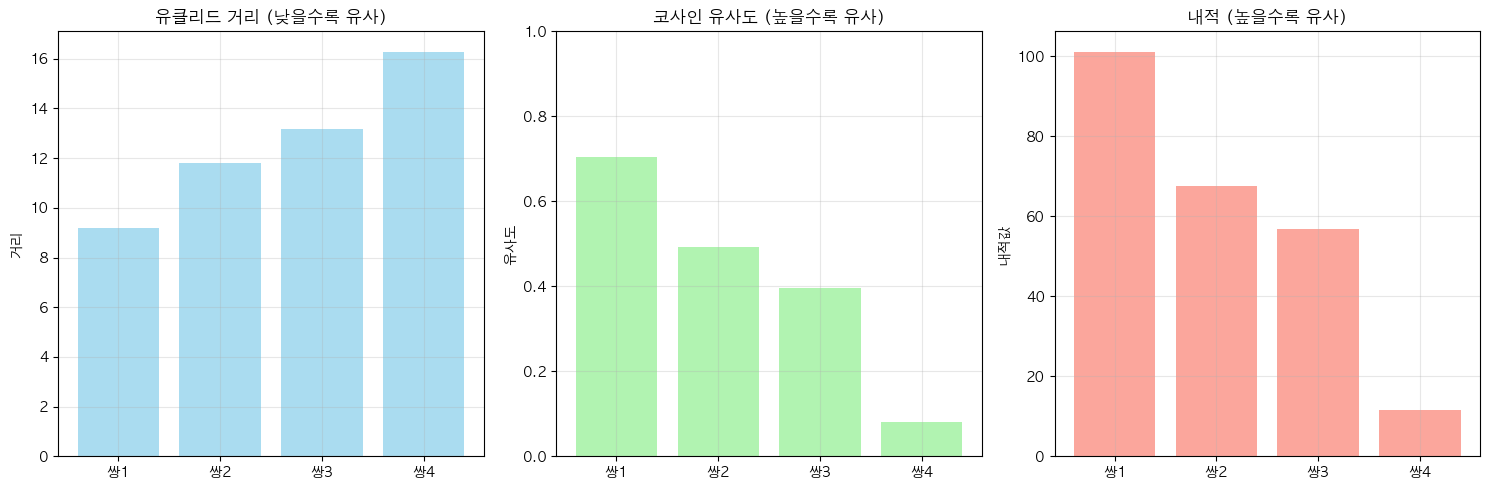

In [31]:
# sbert 모델 결과 시각화
plot_similarity_comparison(sbert_comparison_results)

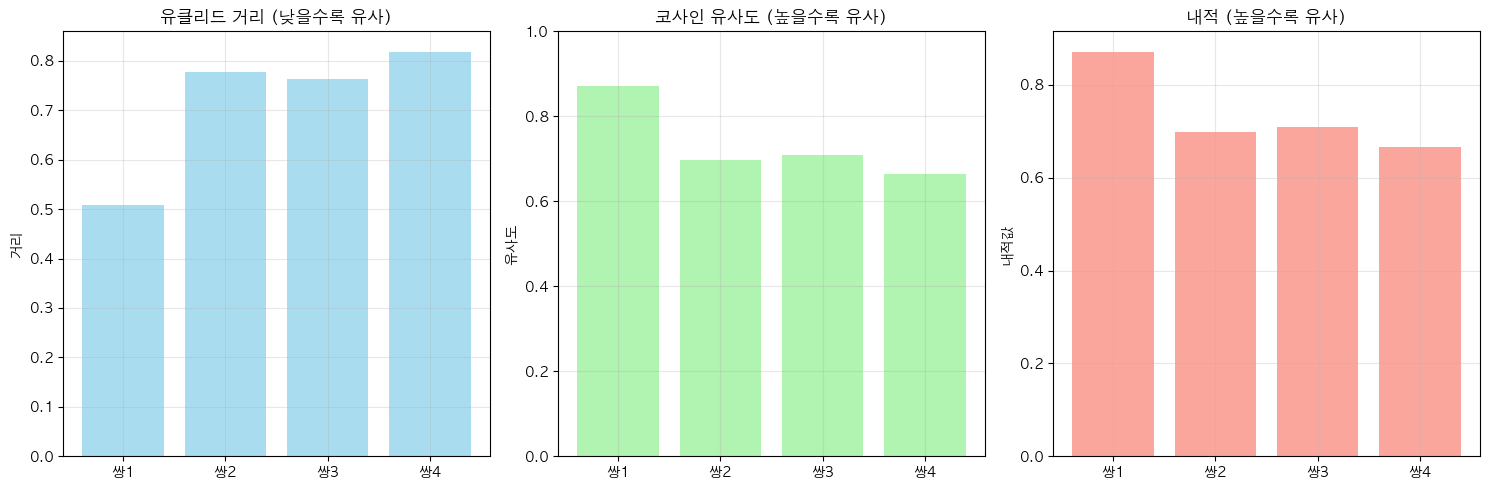

In [32]:
# bge-m3 모델 결과 시각화
plot_similarity_comparison(bge_comparison_results)

---

# **[실습 프로젝트]**

### **문제: 문서 유사도 비교 시스템 구현**

**목표**: 주어진 문서들을 토큰화하고 임베딩한 후 유사도를 비교하는 시스템 구현

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer

# 테스트용 샘플 문서
documents = [
    "인공지능은 컴퓨터 과학의 중요한 분야입니다.",
    "머신러닝은 인공지능의 하위 분야입니다.",
    "딥러닝은 머신러닝의 한 종류입니다.",
    "자연어 처리는 텍스트 데이터를 다룹니다."
]


# 문제 1: 문서를 토큰화하고 BoW 벡터로 변환하시오
def tokenize_documents(docs):
    """
    문서 리스트를 토큰화하고 BoW 벡터로 변환합니다.
    
    힌트:
    - Kiwi 토크나이저를 사용하여 각 문서를 토큰화하세요
    - 구두점(SF, SP 태그)은 제외하세요
    - CountVectorizer를 사용하여 BoW 행렬을 생성하세요
    
    Args:
        docs: 문서 리스트
        
    Returns:
        bow_matrix: BoW 벡터 행렬
        vectorizer: 학습된 CountVectorizer 객체
    """
    # 이 부분을 구현하세요
    pass

# 문제 2: 문서를 임베딩으로 변환하시오
def create_embeddings(docs):
    """
    문서 리스트를 임베딩 벡터로 변환합니다.
    
    힌트:
    - SentenceTransformer 모델을 로드하세요 (ko-sroberta 또는 bge-m3)
    - model.encode() 메서드를 사용하세요
    - 반환값은 numpy 배열입니다
    
    Args:
        docs: 문서 리스트
        
    Returns:
        embeddings: 임베딩 벡터 배열 (n_docs, embedding_dim)
    """
    # 이 부분을 구현하세요
    pass

# 문제 3: 문서들 간의 유사도를 계산하시오
def calculate_similarity(embeddings):
    """
    임베딩 벡터들 간의 코사인 유사도를 계산합니다.
    
    힌트:
    - sklearn.metrics.pairwise.cosine_similarity를 사용하세요
    - 결과는 (n_docs, n_docs) 크기의 유사도 행렬입니다
    - 대각선 값은 자기 자신과의 유사도(1.0)입니다
    
    Args:
        embeddings: 임베딩 벡터 배열
        
    Returns:
        similarity_matrix: 유사도 행렬
    """
    # 이 부분을 구현하세요
    pass

# 문제 4: 가장 유사한 문서 쌍을 찾으시오
def find_most_similar_pair(similarities, docs):
    """
    유사도 행렬에서 가장 유사한 문서 쌍을 찾습니다.
    
    힌트:
    - 대각선 값(자기 자신과의 유사도)은 제외하세요
    - np.fill_diagonal()을 사용하여 대각선을 -1로 설정할 수 있습니다
    - np.unravel_index(np.argmax(similarities), similarities.shape)로 최대값의 인덱스를 얻을 수 있습니다
    
    Args:
        similarities: 유사도 행렬
        docs: 문서 리스트
        
    Returns:
        result: {'most_similar_pair': (문서1, 문서2), 
                'similarity_score': 유사도점수,
                'similarity_matrix': 유사도행렬}
    """
    # 이 부분을 구현하세요
    pass